# CAB420 Assignment 1B
- First Name: Aidan
- Last Name: Lockwood
- Student Number: 10515402

## Question 1: Person Re-Identification

In [ ]:
# Importing the relevant libraries
import os
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
import cv2
import glob
import random

import tensorflow_datasets as tfds

from sklearn import decomposition, discriminant_analysis
from sklearn.manifold import TSNE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import ConfusionMatrixDisplay

import keras
from keras import layers

Utility functions used to preprocess the data - taken from the template

In [ ]:
def get_subject_id_from_filename(fn):
    return int(fn[0:4])

def load_directory(base_path):

    # find all images in the directory
    files = glob.glob(os.path.join(base_path, '*.jpg'))
    x = []
    y = []

    # loop through the images, loading them and extracting the subject ID
    for f in files:
        x.append(cv2.cvtColor(cv2.imread(f), cv2.COLOR_BGR2RGB) / 255.0)
        y.append(get_subject_id_from_filename(os.path.basename(f)))

    return np.array(x), np.array(y)

def split_validation(X, Y, id_cutoff = 250):

    train_X = X[Y <= id_cutoff, :]
    train_Y = Y[Y <= id_cutoff]

    val_X = X[Y > id_cutoff, :]
    val_Y = Y[Y > id_cutoff]

    return train_X, train_Y, val_X, val_Y

def sample_gallery_and_probe(X, Y):

    # storage
    gallery_X = []
    gallery_Y = []
    probe_X = []
    probe_Y = []

    # find unique IDs
    unique_ids = np.unique(Y)
    # loop through unique IDs
    for i in unique_ids:
        # pull out samples for the current ID
        samples = X[Y == i, :]
        # need at least two samples for use the ID
        if samples.shape[0] >= 2:
            # first sample for a subject stored in the gallery
            gallery_X.append(samples[0, :])
            gallery_Y.append(i)
            # second sample stored in the probe
            probe_X.append(samples[1, :])
            probe_Y.append(i)
            # any other images for the subject are ignored

    # return extracted data
    return np.array(gallery_X), np.array(gallery_Y), np.array(probe_X), np.array(probe_Y)

def load_data(base_path):

    # load training data
    train_X, train_Y = load_directory(os.path.join(base_path, 'Training'))
    # split validation data
    train_X, train_Y, val_X, val_Y = split_validation(train_X, train_Y)

    # load gallery data from the test set
    gallery_X, gallery_Y = load_directory(os.path.join(base_path, 'Testing', 'Gallery'))

    # load probe data from the test set
    probe_X, probe_Y = load_directory(os.path.join(base_path, 'Testing', 'Probe'))

    return train_X, train_Y, val_X, val_Y, gallery_X, gallery_Y, probe_X, probe_Y

def plot_images(x, y):
    fig = plt.figure(figsize=[15, 18])
    for i in range(50):
        ax = fig.add_subplot(5, 10, i + 1)
        ax.imshow(x[i,:], cmap=plt.get_cmap('Greys'))
        ax.set_title(y[i])
        ax.axis('off')

def vectorise(images):
    # use numpy's reshape to vectorise the data
    return np.reshape(images, [len(images), -1])

def resize(images, new_size):
    # tensorflow has an image resize funtion that can do this in bulk
    # note the conversion back to numpy after the resize
    return tf.image.resize(images, new_size).numpy()

def convert_to_grayscale(images):
    # storage for converted images
    gray = []
    # loop through images
    for i in range(len(images)):
        # convert each image using openCV
        gray.append(cv2.cvtColor(images[i,:], cv2.COLOR_RGB2GRAY))
    # pack converted list as an array and return
    return np.expand_dims(np.array(gray), axis = -1)

def get_siamese_data(imgs, labels, batch_size):

    image_a = np.zeros((batch_size, np.shape(imgs)[1], np.shape(imgs)[2], np.shape(imgs)[3]));
    image_b = np.zeros((batch_size, np.shape(imgs)[1], np.shape(imgs)[2], np.shape(imgs)[3]));
    label = np.zeros(batch_size);

    for i in range(batch_size):

        if (i % 2 == 0):
            idx1 = random.randint(0, len(imgs) - 1)
            idx2 = random.randint(0, len(imgs) - 1)
            l = 1
            while (labels[idx1] != labels[idx2]):
                idx2 = random.randint(0, len(imgs) - 1)

        else:
            idx1 = random.randint(0, len(imgs) - 1)
            idx2 = random.randint(0, len(imgs) - 1)
            l = 0
            while (labels[idx1] == labels[idx2]):
                idx2 = random.randint(0, len(imgs) - 1)

        image_a[i, :, :, :] = imgs[idx1,:,:,:]
        image_b[i, :, :, :] = imgs[idx2,:,:,:]
        label[i] = l

    return [image_a, image_b], label

def plot_pairs(x, y):
    fig = plt.figure(figsize=[25, 6])
    for i in range(10):
        ax = fig.add_subplot(2, 10, i*2 + 1)
        ax.imshow(x[0][i,:], cmap=plt.get_cmap('Greys'))
        ax.set_title('Pair ' + str(i) +'; Label: ' + str(y[i]))

        ax = fig.add_subplot(2, 10, i*2 + 2)
        ax.imshow(x[1][i,:], cmap=plt.get_cmap('Greys'))
        ax.set_title('Pair ' + str(i) +'; Label: ' + str(y[i]))

def get_triplet_data(imgs, labels, batch_size):

    image_a = np.zeros((batch_size, np.shape(imgs)[1], np.shape(imgs)[2], np.shape(imgs)[3]));
    image_b = np.zeros((batch_size, np.shape(imgs)[1], np.shape(imgs)[2], np.shape(imgs)[3]));
    image_c = np.zeros((batch_size, np.shape(imgs)[1], np.shape(imgs)[2], np.shape(imgs)[3]));

    for i in range(batch_size):

        idx1 = random.randint(0, len(imgs) - 1)
        idx2 = random.randint(0, len(imgs) - 1)
        idx3 = random.randint(0, len(imgs) - 1)

        while (labels[idx1] != labels[idx2]):
            idx2 = random.randint(0, len(imgs) - 1)

        while (labels[idx1] == labels[idx3]):
            idx3 = random.randint(0, len(imgs) - 1)

        image_a[i, :, :, :] = imgs[idx1,:,:,:]
        image_b[i, :, :, :] = imgs[idx2,:,:,:]
        image_c[i, :, :, :] = imgs[idx3,:,:,:]

    return [image_a, image_b, image_c]

def plot_triplets(x):
    fig = plt.figure(figsize=[25, 10])
    for i in range(9):
        ax = fig.add_subplot(3, 9, i*3 + 1)
        ax.imshow(x[0][i,:], cmap=plt.get_cmap('Greys'))
        ax.set_title('Triple ' + str(i) + ': Anchor')

        ax = fig.add_subplot(3, 9, i*3 + 2)
        ax.imshow(x[1][i,:], cmap=plt.get_cmap('Greys'))
        ax.set_title('Triple ' + str(i) + ': Positive')

        ax = fig.add_subplot(3, 9, i*3 + 3)
        ax.imshow(x[2][i,:], cmap=plt.get_cmap('Greys'))
        ax.set_title('Triple ' + str(i) + ': Negative')


def evaluate_model(model, X_train, Y_train, X_test, Y_test):
    fig = plt.figure(figsize=[25, 12])

    ax = fig.add_subplot(1, 2, 1)
    conf = ConfusionMatrixDisplay.from_estimator(model, X_train, Y_train, normalize = 'true', ax = ax)
    conf.ax_.set_title('Training Set Performance')

    ax = fig.add_subplot(1, 2, 2)
    conf = ConfusionMatrixDisplay.from_estimator(model, X_test, Y_test, normalize = 'true', ax = ax)
    conf.ax_.set_title('Test Set Performance')

    predict = model.predict(X_test)
    print(f'Accuracy: {str(sum(predict == Y_test) / len(Y_test))}%')

def get_ranked_histogram_l2_distance(gallery_feat, gallery_Y, probe_feat, probe_Y, verbose = False):

    # storage for ranked histogram
    # length equal to number of unique subjects in the gallery
    ranked_histogram = np.zeros(len(np.unique(gallery_Y)))

    # loop over all samples in the probe set
    for i in range(len(probe_Y)):
        # get the true ID of this sample
        true_ID = probe_Y[i]
        if verbose:
            print('Searching for ID %d' % (true_ID))

        # get the distance between the current probe and the whole gallery, L2 distance here. Note that L2
        # may not always be the best choice, so consider your distance metric given your problem
        dist = np.linalg.norm(gallery_feat - probe_feat[i,:], axis=1, ord=2)
        if verbose:
            print(dist)

        # get the sorted order of the distances
        a = np.argsort(dist)
        # apply the order to the gallery IDs, such that the first ID in the list is the closest, the second
        # ID is the second closest, and so on
        ranked = gallery_Y[a]
        if verbose:
            print('Ranked IDs for query:')
            print(a)

        # find the location of the True Match in the ranked list
        ranked_result = np.where(ranked == true_ID)[0][0]
        if verbose:
            print(ranked_result)

        # store the ranking result in the histogram
        ranked_histogram[ranked_result] += 1
        if verbose:
            print('')

    if verbose:
        print(ranked_histogram)

    return ranked_histogram

# Convert a ranked histogram to a CMC. This simply involves computing the cumulative sum over the histogram
# and dividing it by the length of the histogram
#   ranked_hist: ranked histogram to convert to a CMC
#
#   returns:     CMC curve
#
def ranked_hist_to_CMC(ranked_hist):

    cmc = np.zeros(len(ranked_hist))
    for i in range(len(ranked_hist)):
        cmc[i] = np.sum(ranked_hist[:(i + 1)])

    return (cmc / len(ranked_hist))

# plot a CMC
#   cmc: cmc data to plot
#
def plot_cmc(cmc):
    fig = plt.figure(figsize=[10, 8])
    ax = fig.add_subplot(1, 1, 1)
    ax.plot(range(1, len(cmc)+1), cmc)
    ax.set_xlabel('Rank')
    ax.set_ylabel('Count')
    ax.set_ylim([0, 1.0])
    ax.set_title('CMC Curve')

## Step 1: Prepreprocessing

(4711, 128, 64, 3)
(4711,)
(1222, 128, 64, 3)
(1222,)
(301, 128, 64, 3)
(301,)
(301, 128, 64, 3)
(301,)


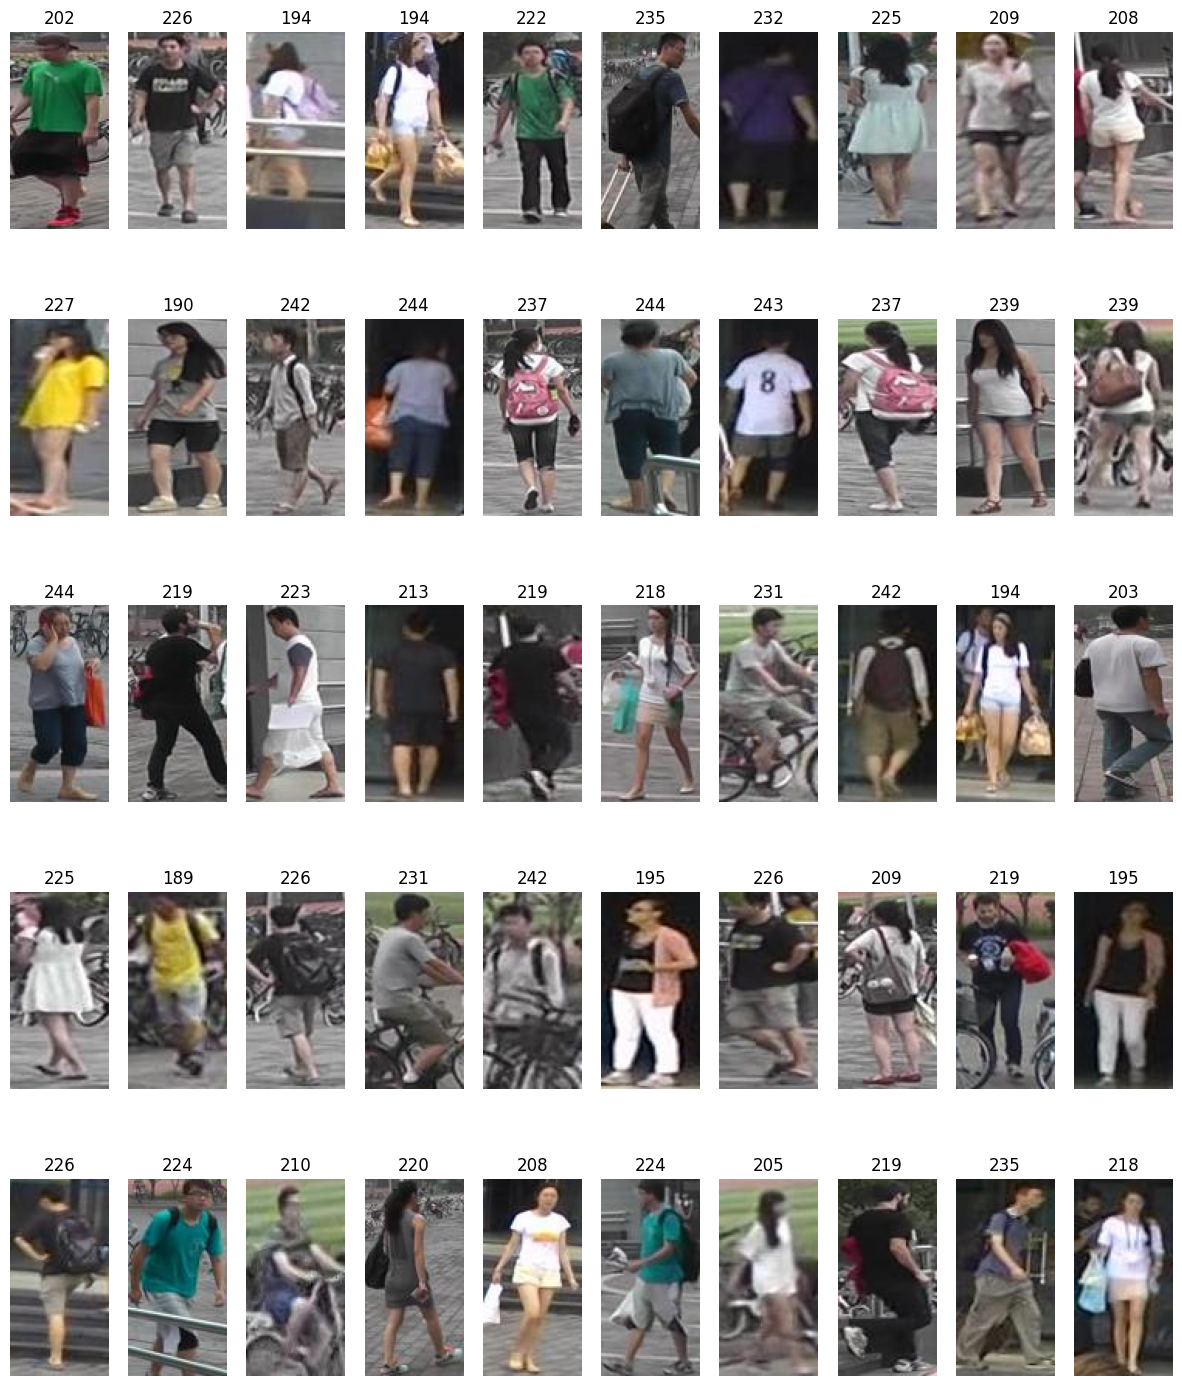

In [ ]:
train_X, train_Y, val_X, val_Y, gallery_X, gallery_Y, probe_X, probe_Y = load_data('drive/MyDrive/data/Q1/')

print(train_X.shape)
print(train_Y.shape)
print(val_X.shape)
print(val_Y.shape)
print(gallery_X.shape)
print(gallery_Y.shape)
print(probe_X.shape)
print(probe_Y.shape)

plot_images(train_X, train_Y)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
val_gallery_X, val_gallery_Y, val_probe_X, val_probe_Y = sample_gallery_and_probe(val_X, val_Y)

Scaling the data

In [ ]:
def standardisation(data):
    mean = np.mean(vectorise(data), axis = 0)
    sigma = np.std(vectorise(data), axis = 0)
    X_standardised = (vectorise(data) - mean) / sigma
    return mean, sigma, X_standardised

In [ ]:
train_mean, train_sigma, train_X_standardised = standardisation(train_X)
probe_mean, probe_sigma, probe_X_standardised = standardisation(probe_X)
gallery_mean, gallery_sigma, gallery_X_standardised = standardisation(gallery_X)

In [ ]:
pca = decomposition.PCA()
pca.fit(train_X_standardised)

transformed_train_X = pca.transform(train_X_standardised)

In [ ]:
transformed_gallery_X = pca.transform(gallery_X_standardised)
transformed_probe_X = pca.transform(probe_X_standardised)

In [ ]:
reduced_train_X = transformed_train_X[:, 0:2]
reduced_gallery_X = transformed_gallery_X[:, 0:2]
reduced_probe_X = transformed_probe_X[:, 0:2]

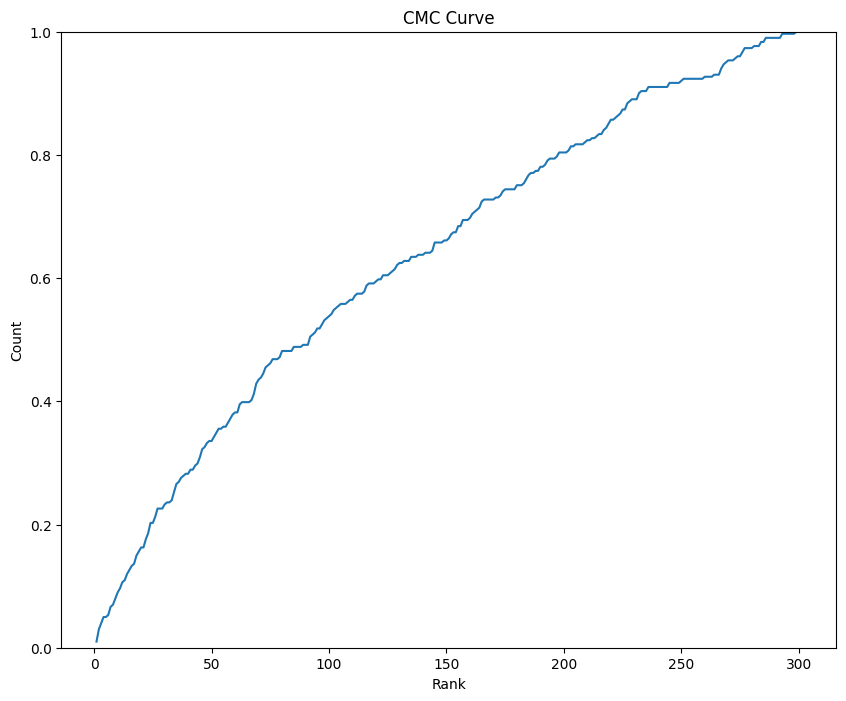

In [ ]:
ranked_histogram = get_ranked_histogram_l2_distance(reduced_gallery_X, gallery_Y, reduced_probe_X, probe_Y)

pca_cmc = ranked_hist_to_CMC(ranked_histogram)
plot_cmc(pca_cmc)

In [ ]:
transformed_gallery_X.shape

(301, 4711)

Applying LDA to the PCA space (standardised)

In [ ]:
lda = discriminant_analysis.LinearDiscriminantAnalysis()

lda.fit(transformed_train_X, train_Y)

transformed_train_X_pca_lda = lda.transform(transformed_train_X)
transformed_gallery_X_pca_lda = lda.transform(transformed_gallery_X)
transformed_probe_X_pca_lda = lda.transform(transformed_probe_X)

In [ ]:
reduced_train_X_pca_lda = transformed_train_X_pca_lda[:, 0:2]
reduced_gallery_X_pca_lda = transformed_gallery_X_pca_lda[:, 0:2]
reduced_probe_X_pca_lda = transformed_probe_X_pca_lda[:, 0:2]

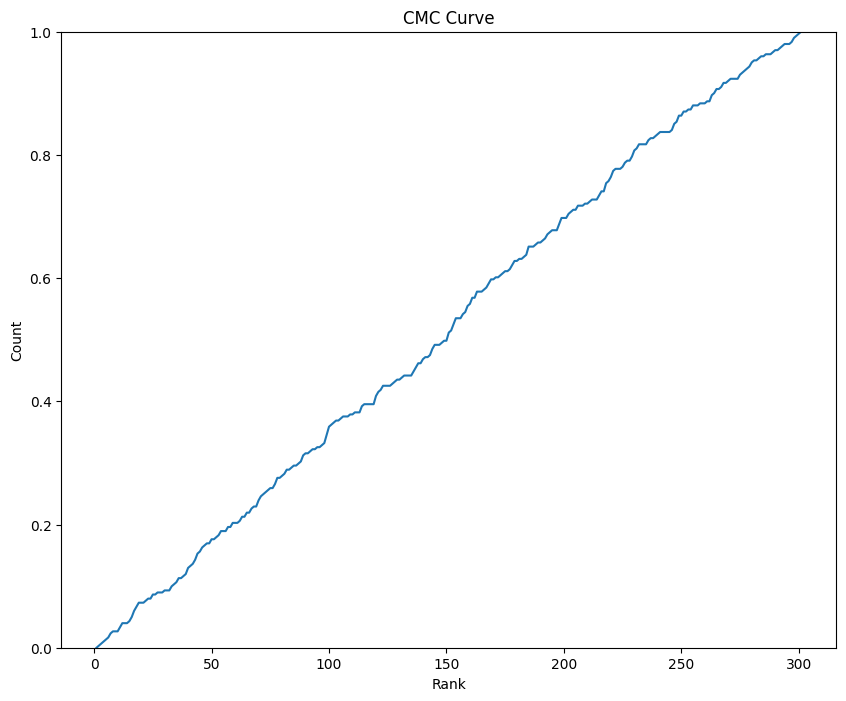

In [ ]:
ranked_histogram = get_ranked_histogram_l2_distance(reduced_gallery_X_pca_lda, gallery_Y, reduced_probe_X_pca_lda, probe_Y)

pca_lda_cmc = ranked_hist_to_CMC(ranked_histogram)
plot_cmc(pca_lda_cmc)

Just LDA by itself

In [ ]:
lda = discriminant_analysis.LinearDiscriminantAnalysis()

lda.fit(train_X_standardised, train_Y)

In [ ]:
lda_train_X = lda.transform(train_X_standardised)
lda_gallery_X = lda.transform(gallery_X_standardised)
lda_probe_X = lda.transform(probe_X_standardised)


In [ ]:
reduced_train_X_lda = lda_train_X[:, 0:2]
reduced_gallery_X_lda = lda_gallery_X[:, 0:2]
reduced_probe_X_lda = lda_probe_X[:, 0:2]

In [ ]:
ranked_histogram = get_ranked_histogram_l2_distance(reduced_gallery_X_lda, gallery_Y, reduced_probe_X_lda, probe_Y)
lda_cmc = ranked_hist_to_CMC(ranked_histogram)

plot_cmc(lda_cmc)

In [ ]:
fig = plt.figure(figsize=[10, 8])
ax = fig.add_subplot(1, 1, 1)
ax.plot(range(1, len(pca_cmc)+1), pca_cmc)
ax.plot(range(1, len(pca_lda_cmc)+1), pca_lda_cmc)
ax.plot(range(1, len(lda_cmc)+1), lda_cmc)
ax.legend(['PCA', 'PCA + LDA', 'LDA'])
ax.set_xlabel('Rank')
ax.set_ylabel('Count')
ax.set_ylim([0, 1.0])
ax.set_title('CMC Curve')

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.scatter(transformed_probe_X[:,0], transformed_probe_X[:,1], c=probe_Y)
ax.set_title('First Two LDA Components')

## Part 2: Deep Learning Method

Dividing the data into the triplets

In [ ]:
triplet_data = get_triplet_data(train_X, train_Y, 1000)
plot_triplets(triplet_data)

Developing the network

In [ ]:
def create_conv_block(inputs, filters, spatial_dropout = 0.0, max_pool = True):

    x = layers.Conv2D(filters=filters, kernel_size=(3,3), padding='same', activation='relu')(inputs)
    x = layers.Conv2D(filters=filters, kernel_size=(3,3), padding='same', activation=None)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    if (spatial_dropout > 0.0):
        x = layers.SpatialDropout2D(spatial_dropout)(x)
    if (max_pool == True):
        x = layers.MaxPool2D(pool_size=(2, 2))(x)

    return x

def normalise_vector(vect):
    # get the magnitude for each vector in the batch
    mag = keras.ops.sqrt(keras.ops.sum(keras.ops.square(vect), axis=1))
    # repeat this, so we now have as many elements in mag as we do in vect
    mag = keras.ops.reshape(keras.ops.repeat(mag, vect.shape[1], axis=0), (-1, vect.shape[1]))
    # element wise division
    return keras.ops.divide(vect, mag)

class TripletLossLayer(layers.Layer):
    def __init__(self, alpha, **kwargs):
        self.alpha = alpha
        super(TripletLossLayer, self).__init__(**kwargs)

    def triplet_loss(self, inputs):
        anchor, positive, negative = inputs

        anchor = normalise_vector(anchor)
        positive = normalise_vector(positive)
        negative = normalise_vector(negative)

        p_dist = keras.ops.sum(keras.ops.square(anchor-positive), axis=-1)
        n_dist = keras.ops.sum(keras.ops.square(anchor-negative), axis=-1)
        return keras.ops.sum(keras.ops.maximum(p_dist - n_dist + self.alpha, 0), axis=0)

    def call(self, inputs):
        loss = self.triplet_loss(inputs)
        self.add_loss(loss)
        return loss

def fc_block(inputs, size, dropout):
    x = layers.Dense(size, activation=None)(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    if (dropout > 0.0):
        x = layers.Dropout(dropout)(x)

    return x

def vgg_net(inputs, filters, fc, spatial_dropout = 0.0, dropout = 0.0):

    x = inputs
    for idx,i in enumerate(filters):
        x = create_conv_block(x, i, spatial_dropout, not (idx==len(filters) - 1))

    x = layers.Flatten()(x)

    for i in fc:
        x = fc_block(x, i, dropout)

    return x

dummy = keras.Input((128, 64, 3), name = 'Anchor')
base_network = vgg_net(dummy, [8, 16, 32], [256], 0.2, 0)
embedding_layer = layers.Dense(32, activation=None)(base_network)
base_network = keras.models.Model(inputs = dummy, outputs = embedding_layer)

input_anchor = keras.Input((128, 64, 3), name = 'Anchor')
input_positive = keras.Input((128, 64, 3), name = 'Positive')
input_negative = keras.Input((128, 64, 3), name = 'Negative')

embedding_anchor = base_network(input_anchor)
embedding_positive = base_network(input_positive)
embedding_negative = base_network(input_negative)

triplet_loss_layer = TripletLossLayer(1, name = 'TripletLossLayer')([embedding_anchor, embedding_positive, embedding_negative])

triplet_network = keras.models.Model(inputs = [input_anchor, input_positive, input_negative], outputs = triplet_loss_layer)

Preparing the triplet data

In [ ]:
triplet_train_X = get_triplet_data(train_X, train_Y, 1000)
triplet_val_X = get_triplet_data(val_X, val_Y, 1000)
triplet_gallery_X = get_triplet_data(gallery_X, gallery_Y, 1000)
triplet_probe_X = get_triplet_data(probe_X, probe_Y, 1000)

In [ ]:
triplet_network.compile(optimizer = keras.optimizers.Adam(), jit_compile = False)
triplet_network.fit(x = triplet_train_X, y = None, epochs = 10, batch_size = 128, validation_data = (triplet_val_X, None))

Analysing the performance of the model

In [ ]:
def compute_distance(x, y):
    x = normalise_vector(x)
    y = normalise_vector(y)

    distance = keras.ops.sum(keras.ops.square(x - y), axis=1)
    return distance

x = get_triplet_data(gallery_X, gallery_Y, 9)

anchor_embedding = base_network.predict(x[0])
positive_embedding = base_network.predict(x[1])
negative_embedding = base_network.predict(x[2])

positive_distance = compute_distance(anchor_embedding, positive_embedding)
negative_distance = compute_distance(anchor_embedding, negative_embedding)

fig = plt.figure(figsize=[25, 9])
for i in range(9):
    ax = fig.add_subplot(3, 9, i * 3 + 1)
    ax.imshow(triplet_probe_X[0][i, :, :, 0])
    ax.set_title(f'Anchor {i}')

    ax = fig.add_subplot(3, 9, i * 3 + 2)
    ax.imshow(triplet_probe_X[1][i, :, :, 0])
    ax.set_title(f'Positive {positive_distance[i]}')

    ax = fig.add_subplot(3, 9, i * 3 + 3)
    ax.imshow(triplet_probe_X[2][i, :, :, 0])
    ax.set_title(f'Negative {negative_distance[i]}')

Looking at the distribution of values between the positive and negatives

In [ ]:
anchor_embedding = base_network.predict(triplet_gallery_X[0])
positive_embedding = base_network.predict(triplet_gallery_X[1])
negative_embedding = base_network.predict(triplet_gallery_X[2])

positive_distance = compute_distance(anchor_embedding, positive_embedding)
negative_distance = compute_distance(anchor_embedding, negative_embedding)

fig = plt.figure(figsize=[12, 12])
ax = fig.add_subplot(1, 1, 1)

ax.set_yscale('log')

ax.hist(positive_distance, np.arange(0, 4, 0.1), label = 'Positive Pairs', fc = (0, 0, 1.0, 0.5), alpha = 0.75)
ax.hist(negative_distance, np.arange(0, 4, 0.1), label = 'Negative Pairs', fc = (1.0, 0, 0, 0.5), alpha = 0.75)
ax.legend()

In [ ]:
probe_embeddings = base_network.predict(probe_X)
gallery_embeddings = base_network.predict(gallery_X)

tsne_embeddings = TSNE(random_state = 4).fit_transform(probe_embeddings)

fig = plt.figure(figsize=[12, 12])
ax = fig.add_subplot(1, 1, 1)
ax.scatter(tsne_embeddings[:, 0], tsne_embeddings[:, 1], c = probe_Y.flatten())

In [ ]:
ranked_histogram_triplet = get_ranked_histogram_l2_distance(gallery_embeddings, gallery_Y, probe_embeddings, probe_Y)

triplet_cmc = ranked_hist_to_CMC(ranked_histogram_triplet)
plot_cmc(triplet_cmc)

# Question 2: Multi Task Learning

Bringing in the functions from the template for the problem

In [ ]:
def preprocess_segmentation_mask(segmentation_mask):
    return tf.abs(tf.cast(segmentation_mask, tf.float32) - 2)

def return_image_label_mask(ds_out):
    # preprocess the segmentation mask
    seg_mask =  preprocess_segmentation_mask(ds_out['segmentation_mask'])
    image = tf.cast(ds_out['image'], tf.float32)
    # image = standardise_image(image)
    return image, (ds_out['label'], seg_mask)

def mobilenet_preprocess_image(image):
    image = (image - 127.5) / 255.0
    return image

def unprocess_image(image):
    """ undo preprocessing above so can plot images"""
    image = image * 255.0 + 127.5
    return image

def preprocess_and_resize(image, output, image_size):
    # resize the image and the semantic segmentation mask
    image = tf.image.resize(image, [image_size, image_size])
    image = mobilenet_preprocess_image(image)
    mask = tf.image.resize(output[1], [image_size, image_size])
    return image, (output[0], mask)

def flip_lr_augmentation(image, output, flip_lr_prob):
    # randomly sample a value between 0 and 1
    uniform_sample = tf.random.uniform([], minval=0, maxval=1)
    # perform flip_lr with probability given by flip_lr_prob
    flip_lr_cond = tf.math.less(uniform_sample, flip_lr_prob)
    # output is a tuple of (class, segmentation_mask), pull out the segmentation mask
    seg = output[1]

    # wrapper fn for when we do the flip
    def flip():
        flipped_image = tf.image.flip_left_right(image)
        flipped_seg = tf.image.flip_left_right(seg)
        return flipped_image, flipped_seg

    # wrapper fn for when we do NOT flip
    def no_flip():
        return image, seg

    # apply augmentation
    image, seg = tf.cond(flip_lr_cond, flip, no_flip)
    # return the image, and output
    return image, (output[0], seg)

def select_tasks(image, output, classification=True, segmentation=True):
    # both tasks
    if classification and segmentation:
        return image, output
    # just classification
    elif classification:
        return image, output[0]
    # just segmentation
    elif segmentation:
        return image, output[1]
    # neither task, doesn't really make sense, so return the image
    # for a self-supervised task
    else:
        return image, image

class TrainForTime(keras.callbacks.Callback):
    def __init__(
        self,
        train_time_mins=15,
    ):
        super().__init__()

        self.train_time_mins = train_time_mins
        self.epochs = 0
        self.train_time = 0
        self.end_early = False

    def on_train_begin(self, logs=None):
        # save the start time
        self.start_time = tf.timestamp()

    def on_epoch_end(self, epoch, logs=None):
        self.epochs += 1
        current_time = tf.timestamp()
        training_time = (current_time - self.start_time)
        if (training_time / 60) > self.train_time_mins:
            self.train_time = current_time - self.start_time
            self.model.stop_training = True
            self.end_early = True


    def on_train_end(self, logs=None):
        if self.end_early:
            print('training time exceeded and ending early')
            print(f'training ended on epoch {self.epochs}')
            print(f'training time = {self.train_time / 60} mins')

def load_oxford_pets(split,
                     batch_size=233,
                     classification=True,
                     segmentation=True,
                     shuffle=True,
                     augment=True,
                     image_size=300):
    # lets do some error checking first
    # Check fior a valid dataset split, this must be train or test
    if (split != 'train') and (split != 'val') and (split != 'test'):
        raise ValueError('Arg for split must be either \'train\' or \'test\'')
    if (not classification) and (not segmentation):
        print("WARNING: One of the tasks (classification and segmentation) must be selected")
        print("Setting both to enabled")
        classification = True
        segmentation = True

    # check that if using the val split, shuffle if false. If not, print a warning and force shuffle to be false
    if (split == 'val') and shuffle:
        print("WARNING: shuffle is set to true, but have specified split to be \'val\'")
        print('The shuffle argument will be ignored')
        shuffle = False

    # check that if using the test split, shuffle if false. If not, print a warning and force shuffle to be false
    if (split == 'test') and shuffle:
        print("WARNING: shuffle is set to true, but have specified split to be \'test\'")
        print('The shuffle argument will be ignored')
        shuffle = False

    # check that if using the val split, augment if false. If not, print a warning and force augment to be false
    if (split == 'val') and augment:
        print("WARNING: augment is set to true, but have specified split to be \'val\'")
        print('The augment argument will be ignored')
        augment = False

    # check that if using the test split, augment if false. If not, print a warning and force augment to be false
    if (split == 'test') and augment:
        print("WARNING: augment is set to true, but have specified split to be \'test\'")
        print('The augment argument will be ignored')
        augment = False

    # the dataset by default only has train and test splits. If val is requested, pull the first 30% of the test set
    if (split == 'val'):
        split = 'test[:30%]'
    # the test set then becomes the remaining 70% of the original test set
    elif (split == 'test'):
        split = 'test[30%:]'

    # now start loading the dataset
    ds = tfds.load('oxford_iiit_pet',
                   split=split,
                   with_info=False)

    # remove unnecessary dataset info
    ds = ds.map(return_image_label_mask)

    # augmentation
    # only apply if in the training split and augment has been set to True
    if split == 'train' and augment:
        # apply a left-right flip with 50% probability
        flip_lr_prob = 0.5
        # flip operation
        ds = ds.map(lambda inp, out: flip_lr_augmentation(inp, out, flip_lr_prob), num_parallel_calls=tf.data.AUTOTUNE)

        # more augmentation operations could go here .....

    # Final processing of the data
    # here we will resize the data, and add the preprocessing that is needed for compatability with the mobilenet models.
    ds = ds.map(lambda inp, out: preprocess_and_resize(inp, out, image_size))

    # and now remove any tasks that we don't want. Note that we call this last as it means that all the other functions
    # can safely assume that data for both tasks is in the dataset
    ds = ds.map(lambda inp, out: select_tasks(inp, out, classification, segmentation))

    # if in the training split, and shuffle is true, shuffle the data
    if split == 'train' and shuffle:
        ds = ds.shuffle(1000)

    # return the loaded and processed dataset
    return ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

Ensuring the data loading is working well

In [ ]:
image_size = 256
batch_size = 128

training_class_segment = load_oxford_pets('train',
                                  classification = True,
                                  segmentation = True,
                                  shuffle = True,
                                  augment = True,
                                  image_size = image_size,
                                  batch_size = batch_size)
validation_class_segment = load_oxford_pets('val',
                                      classification = True,
                                      segmentation = True,
                                      shuffle = False,
                                      augment = False,
                                      image_size = image_size,
                                      batch_size = batch_size)
test_class_segment = load_oxford_pets('test',
                                    classification = True,
                                    segmentation = True,
                                    shuffle = False,
                                    augment = False,
                                    image_size = image_size,
                                    batch_size = batch_size)


In [ ]:
fig, axs = plt.subplots(2, 3, figsize=(8, 4), layout = 'constrained')
num_plot = 3
i = 0

for image, output in training_class_segment.take(1).as_numpy_iterator():
    for i in range(num_plot):
        im = axs[0, i].imshow(np.squeeze(unprocess_image(image[i, ...])) / 255.0)
        axs[0, i].set_title(output[0][i])
        axs[0, i].axis('off')
        im = axs[1, i].imshow(np.squeeze(output[1][i, ...]))
        axs[1, i].axis('off')

        print(output[1].shape)
        i += 1
        if i >= num_plot:
            break

Building the network

In [ ]:
input = keras.Input(shape = (128, 256, 256), name = 'Pets-Input')

conv_2d_layer_one = layers.Conv2D(8, (3, 3), activation = 'relu')(input)
conv_2d_layer_two = layers.Conv2D(16, (3, 3), activation = 'relu')(conv_2d_layer_one)
max_pooling_layer_one = layers.MaxPooling2D((2, 2))(conv_2d_layer_two)

conv_2d_layer_three = layers.Conv2D(32, (3, 3), activation = 'relu')(max_pooling_layer_one)
conv_2d_layer_four = layers.Conv2D(64, (3, 3), activation = 'relu')(conv_2d_layer_three)
max_pooling_layer_two = layers.MaxPooling2D((2, 2))(conv_2d_layer_four)

conv_2d_layer_five = layers.Conv2D(128, (3, 3), activation = 'relu')(max_pooling_layer_two)
flatten_layer = layers.Flatten()(conv_2d_layer_five)

dense_layer_one = layers.Dense(128, activation = 'relu')(flatten_layer)
dense_layer_two = layers.Dense(64, activation = 'relu')(flatten_layer)

img_classification = layers.Dense(37, name = 'image_classification')


